In [21]:
# These lines are for google colab, comment or delete if run locally

# Run these lines and then restart session for them to take effect.
#!pip install datasets
#!pip install accelerate -U
#!pip install transformers[torch]

#from google.colab import drive
#drive.mount('/content/drive')

In [22]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification
from datasets import load_dataset, DatasetDict, Dataset
import torch
import pandas as pd
import gc
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [23]:
train_mode = 0

In [24]:
#Choose either the standard

'''
# Load the tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
'''

# Load the tokenizer
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Load the model
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
if train_mode == 1:
  # Load your dataset
  # Assumes dataset is in a format suitable for Hugging Face's `datasets` library
  df = pd.read_csv('dataset_clean_2000_shuffle.csv', delimiter=',')
  dataset = Dataset.from_pandas(df)

  # Preprocessing function to tokenize the input
  def preprocess_function(examples):
      return tokenizer(examples['phrase'], examples['context'], truncation=True, padding='max_length', max_length=500)

  # Apply preprocessing to the dataset
  encoded_dataset = dataset.map(preprocess_function, batched=True)

  # Ensure the dataset has labels
  encoded_dataset = encoded_dataset.rename_column('sentiment', 'labels')


In [26]:
'''
if train_mode == 1:
  # Split the dataset into train and test sets
  train_test_split = encoded_dataset.train_test_split(test_size=0.2)
  train_dataset = train_test_split['train']
  test_dataset = train_test_split['test']

  # Set the format for PyTorch tensors
  train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  '''

"\nif train_mode == 1:\n  # Split the dataset into train and test sets\n  train_test_split = encoded_dataset.train_test_split(test_size=0.2)\n  train_dataset = train_test_split['train']\n  test_dataset = train_test_split['test']\n\n  # Set the format for PyTorch tensors\n  train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])\n  test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])\n  "

In [27]:
if train_mode == 1:
  # Split the dataset into train and test sets

  #train_test_split = encoded_dataset.train_test_split(test_size=0.2)
  #train_dataset = train_test_split['train']
  #test_dataset = train_test_split['test']

  # Perform the initial split into train and temp (to be further split into val and test)
  initial_split = encoded_dataset.train_test_split(test_size=0.2, seed=42)

  # Extract train and temporary datasets
  train_dataset = initial_split['train']
  temp_dataset = initial_split['test']

  # Perform the second split on the temporary dataset into validation and test
  final_split = temp_dataset.train_test_split(test_size=0.5, seed=42)

  # Extract validation and test datasets
  val_dataset = final_split['train']
  test_dataset = final_split['test']

  #train_dataset = train_dataset.train_test_split(test_size=0.2, seed=42)['test']

  #train_dataset, df_temp = train_test_split(encoded_dataset, test_size=0.2, random_state=42)

  # Split the temporary data into validation (10%) and test (10%) sets
  #val_dataset, test_dataset = train_test_split(df_temp, test_size=0.5, random_state=42)


  # Set the format for PyTorch tensors
  train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [28]:
print()

In [29]:
if train_mode == 1:
    print(train_dataset)
    #print(train_dataset['context'])
    gc.collect()

In [30]:
# Define a function to compute metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc
    }

In [31]:
if train_mode == 1:
  # Define the training arguments
  training_args = TrainingArguments(
      output_dir='./results',  # output directory
      num_train_epochs=3,      # number of training epochs
      per_device_train_batch_size=8,  # batch size for training
      per_device_eval_batch_size=8,   # batch size for evaluation
      warmup_steps=500,        # number of warmup steps for learning rate scheduler
      weight_decay=0.01,       # strength of weight decay
      logging_dir='./logs',    # directory for storing logs
      logging_steps=10,
      eval_strategy="epoch",
      load_best_model_at_end=True,
      save_strategy="epoch",
  )

  # Define the Trainer
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics
  )

  # Train the model
  trainer.train()

In [38]:
# Save the model
model_path = 'sentiment_model_new_test'  # path to the saved model

if train_mode == 1:
  model.save_pretrained(model_path)
  tokenizer.save_pretrained(model_path)

In [39]:
# Load the tokenizer and model

tokenizer = RobertaTokenizer.from_pretrained(model_path)
model_eval = RobertaForSequenceClassification.from_pretrained(model_path,num_labels=2 )

# Function to make predictions
def predict_sentiment(phrase, context):
    inputs = tokenizer(phrase, context, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    with torch.no_grad():
        outputs = model_eval(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    print(predicted_class_id)
    return "positive" if predicted_class_id == 1 else "negative"

In [40]:
# Another example usage
phrase = "very good"
context = "The pillows are very good"
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")


# Another example usage
phrase = "very stiff"
context = "The pillows were very stiff, they are uncomfortable"
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

# Another example usage
phrase = "cheap"
context = "The pillows were very stiff, and they were cheap"
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

# Another example usage
phrase = "uncomfortable"
context = "The pillows were very stiff, they are uncomfortable"
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

# Another example usage
phrase = "clean"
context = "The pillows were very stiff, but they were clean"
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

# Another example usage
phrase = "very stiff"
context = "The pillows were very stiff, but they were clean"
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

# Another example usage
phrase = "very soft"
context = "The pillows were very soft, and they were cheap"
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

# Another example usage
phrase = "cheap"
context = "The pillows were very soft, and they were cheap"
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

# Another example usage
phrase = "great value"
context = "The product is great value"
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")


phrase = "is really nice"
context = "Nice shampoo for the money. I get Keratin treatments at the salon at least 3-4 times a year (would do it more often if I could afford it). I am always in the market to use products that can help extend my salon visits. This Keratin shampoo is really nice. It is sulfate free (which is the first thing I look for ) and makes my hair feel silky smooth and soft. I highly recommend for anyone who wants to improve the texture and appearance of your hair. I really like the fragrance, too."
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

phrase = "really like"
context = "Nice shampoo for the money. I get Keratin treatments at the salon at least 3-4 times a year (would do it more often if I could afford it). I am always in the market to use products that can help extend my salon visits. This Keratin shampoo is really nice. It is sulfate free (which is the first thing I look for ) and makes my hair feel silky smooth and soft. I highly recommend for anyone who wants to improve the texture and appearance of your hair. I really like the fragrance, too."
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

phrase = " faux hair is very shiny"
context = "halo hair extensions. This halo hair extension is simply put, garbage.  Now, you get what you pay for.  And this is a very cheap version.  The faux hair is very shiny and looks literally like bad barbie hair.  It looks WAY better in the photos than in real life.  The color is horrific, in my opinion of course.  The streaks are like paint strips.  And all of that would be one thing - but the worst is that the hair completely fell out!  I had hand fulls of hair strands just trying to put the halo on!  And you might think - well, maybe a little loss is to be expected?  Except this was handfuls and handfuls.  I literally dropped the whole thing right into the trash.  I would say this one is a pass for hair loss alone.  Having said all of this, I never hesitate to update my reviews should new info seem useful. All of my reviews reflect my honest, personal experience with the reviewed item - your experience may be different. I am not influenced by any outside source. I receive/accept NO free products or discounts that are not available to all shoppers- ever. For some reason our shopper ranks are no longer visible - so, to give you a little more info about me, I am a top 50 reviewer (#30 the highest rank achieved). Those numbers used to fluctuate over time - up and down but I noticed that they stopped updating regularly - perhaps to phase them out. It's a shame because it did help you see who has been around the longest and who is a trustworthy reviewer.\u00a0 I've been doing reviews for over 25 years with Amazon - over 6,000 reviews posted, those reviews have been viewed well over 50,000 times, including well over 25,000 likes. Bottom line, I pay for all my stuff, just like you do."
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

phrase = "hair is very shiny"
context = "halo hair extensions. This halo hair extension is simply put, garbage.  Now, you get what you pay for.  And this is a very cheap version.  The faux hair is very shiny and looks literally like bad barbie hair.  It looks WAY better in the photos than in real life.  The color is horrific, in my opinion of course.  The streaks are like paint strips.  And all of that would be one thing - but the worst is that the hair completely fell out!  I had hand fulls of hair strands just trying to put the halo on!  And you might think - well, maybe a little loss is to be expected?  Except this was handfuls and handfuls.  I literally dropped the whole thing right into the trash.  I would say this one is a pass for hair loss alone.  Having said all of this, I never hesitate to update my reviews should new info seem useful. All of my reviews reflect my honest, personal experience with the reviewed item - your experience may be different. I am not influenced by any outside source. I receive/accept NO free products or discounts that are not available to all shoppers- ever. For some reason our shopper ranks are no longer visible - so, to give you a little more info about me, I am a top 50 reviewer (#30 the highest rank achieved). Those numbers used to fluctuate over time - up and down but I noticed that they stopped updating regularly - perhaps to phase them out. It's a shame because it did help you see who has been around the longest and who is a trustworthy reviewer.\u00a0 I've been doing reviews for over 25 years with Amazon - over 6,000 reviews posted, those reviews have been viewed well over 50,000 times, including well over 25,000 likes. Bottom line, I pay for all my stuff, just like you do."
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

phrase = "streaks are like paint strips"
context = "halo hair extensions. This halo hair extension is simply put, garbage.  Now, you get what you pay for.  And this is a very cheap version.  The faux hair is very shiny and looks literally like bad barbie hair.  It looks WAY better in the photos than in real life.  The color is horrific, in my opinion of course.  The streaks are like paint strips.  And all of that would be one thing - but the worst is that the hair completely fell out!  I had hand fulls of hair strands just trying to put the halo on!  And you might think - well, maybe a little loss is to be expected?  Except this was handfuls and handfuls.  I literally dropped the whole thing right into the trash.  I would say this one is a pass for hair loss alone.  Having said all of this, I never hesitate to update my reviews should new info seem useful. All of my reviews reflect my honest, personal experience with the reviewed item - your experience may be different. I am not influenced by any outside source. I receive/accept NO free products or discounts that are not available to all shoppers- ever. For some reason our shopper ranks are no longer visible - so, to give you a little more info about me, I am a top 50 reviewer (#30 the highest rank achieved). Those numbers used to fluctuate over time - up and down but I noticed that they stopped updating regularly - perhaps to phase them out. It's a shame because it did help you see who has been around the longest and who is a trustworthy reviewer.\u00a0 I've been doing reviews for over 25 years with Amazon - over 6,000 reviews posted, those reviews have been viewed well over 50,000 times, including well over 25,000 likes. Bottom line, I pay for all my stuff, just like you do."
prediction = predict_sentiment(phrase, context)
print(f"Phrase: '{phrase}'\nContext: '{context}'\nPrediction: {prediction}")
print("")

1
Phrase: 'very good'
Context: 'The pillows are very good'
Prediction: positive

0
Phrase: 'very stiff'
Context: 'The pillows were very stiff, they are uncomfortable'
Prediction: negative

0
Phrase: 'cheap'
Context: 'The pillows were very stiff, and they were cheap'
Prediction: negative

0
Phrase: 'uncomfortable'
Context: 'The pillows were very stiff, they are uncomfortable'
Prediction: negative

1
Phrase: 'clean'
Context: 'The pillows were very stiff, but they were clean'
Prediction: positive

0
Phrase: 'very stiff'
Context: 'The pillows were very stiff, but they were clean'
Prediction: negative

1
Phrase: 'very soft'
Context: 'The pillows were very soft, and they were cheap'
Prediction: positive

0
Phrase: 'cheap'
Context: 'The pillows were very soft, and they were cheap'
Prediction: negative

1
Phrase: 'great value'
Context: 'The product is great value'
Prediction: positive



Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


1
Phrase: 'is really nice'
Context: 'Nice shampoo for the money. I get Keratin treatments at the salon at least 3-4 times a year (would do it more often if I could afford it). I am always in the market to use products that can help extend my salon visits. This Keratin shampoo is really nice. It is sulfate free (which is the first thing I look for ) and makes my hair feel silky smooth and soft. I highly recommend for anyone who wants to improve the texture and appearance of your hair. I really like the fragrance, too.'
Prediction: positive

1
Phrase: 'really like'
Context: 'Nice shampoo for the money. I get Keratin treatments at the salon at least 3-4 times a year (would do it more often if I could afford it). I am always in the market to use products that can help extend my salon visits. This Keratin shampoo is really nice. It is sulfate free (which is the first thing I look for ) and makes my hair feel silky smooth and soft. I highly recommend for anyone who wants to improve the textu

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


0
Phrase: ' faux hair is very shiny'
Context: 'halo hair extensions. This halo hair extension is simply put, garbage.  Now, you get what you pay for.  And this is a very cheap version.  The faux hair is very shiny and looks literally like bad barbie hair.  It looks WAY better in the photos than in real life.  The color is horrific, in my opinion of course.  The streaks are like paint strips.  And all of that would be one thing - but the worst is that the hair completely fell out!  I had hand fulls of hair strands just trying to put the halo on!  And you might think - well, maybe a little loss is to be expected?  Except this was handfuls and handfuls.  I literally dropped the whole thing right into the trash.  I would say this one is a pass for hair loss alone.  Having said all of this, I never hesitate to update my reviews should new info seem useful. All of my reviews reflect my honest, personal experience with the reviewed item - your experience may be different. I am not influenced 

In [41]:
df = pd.read_csv('dataset_balanced_test.csv', delimiter=',')
df.rename(columns={'sentiment': 'labels'}, inplace=True)

test_dataset_eval = Dataset.from_pandas(df)

test_dataset_eval = preprocess_function(test_dataset_eval)

#test_dataset_eval = test_dataset_eval.rename_column('sentiment', 'labels')

#def preprocess_function(examples):
#      return tokenizer(examples['phrase'], examples['context'], truncation=True, padding='max_length', max_length=500)
# Remove rows with NaN values
df.dropna(subset=['phrase', 'context', 'labels'], inplace=True)

# Preprocess the validation dataset
def preprocess_data_2(df, tokenizer):
    # Ensure that 'phrase' and 'context' columns are strings
    df['phrase'] = df['phrase'].astype(str)
    df['context'] = df['context'].astype(str)

    # Combine 'phrase' and 'context' into a single input string
    combined_input = df['phrase'] + " " + df['context']

    # Tokenize the combined input
    inputs = tokenizer(
        combined_input.tolist(),
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    labels = torch.tensor(df['labels'].tolist())

    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    return dataset


eval_dataset = preprocess_data_2(df, tokenizer)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

print(eval_dataloader)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [42]:
# Run predictions on the validation dataset
model_eval.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in eval_dataloader:
        inputs, masks, labels = batch
        outputs = model_eval(input_ids=inputs, attention_mask=masks)
        logits = outputs.logits
        predictions.append(logits)
        true_labels.append(labels)

predictions = torch.cat(predictions, dim=0)
true_labels = torch.cat(true_labels, dim=0)

# Check for NaN values in true_labels
if torch.isnan(true_labels).any():
    raise ValueError("NaN values found in true_labels after processing.")

# Convert logits to probabilities
probs = torch.nn.functional.softmax(predictions, dim=1)[:, 1]
preds = torch.argmax(predictions, dim=1)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84       500
           1       0.81      0.90      0.85       500

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



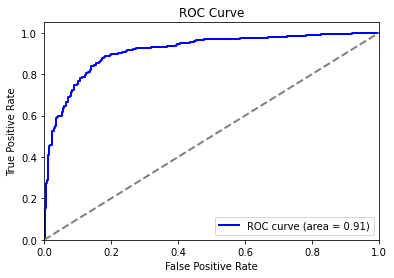

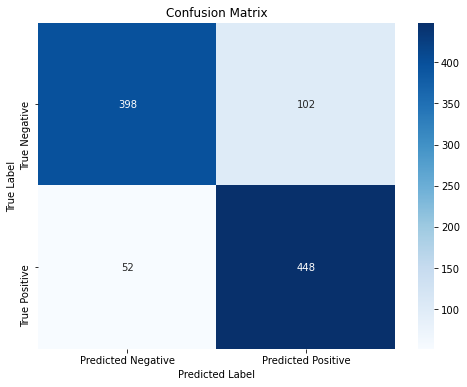

In [43]:
# Calculate performance metrics
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = roc_auc_score(true_labels, probs)
conf_matrix = confusion_matrix(true_labels, preds)
class_report = classification_report(true_labels, preds)

# Print the classification report
print("Classification Report:\n", class_report)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()